# Base Line - Shallow Clustering Methods
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script implements **kMeans** clustering for comparisson with the AEs.  
This includes:
1. kMeans on Original Space.
2. KUMAP - kMeans on UMAP space (dim = k).  


In [8]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [9]:
on_gradient = False
directory = os.getcwd()
if directory == '/notebooks':
    on_gradient = True

In [10]:
if on_gradient == True:
    ! pip install plotly
    ! pip install umap-learn

In [11]:
import plotly.express as px
import plotly.graph_objects as go
import umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
import Transform

In [12]:
# Set Random Seeds
np.random.seed(42)

---
# Script Variables

In [14]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
max_num_clusters = 25

In [15]:
# Uses name to navigate folders
window_cols, window_len = Transform.retrive_window_col_names(dataset_name)
if on_gradient == False:
    dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
    dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'
else:
    gradient_mountedfiles = ! ls /datasets/s3_bucket #!ls /datasets/kenya-90k-set-1-w90
    print(f'Datasets mounted: {gradient_mountedfiles}')
    dataset_location = f'/datasets/s3_bucket/{dataset_name}.csv'

---
# Data Imports

In [17]:
Data = pd.read_csv(dataset_location)

In [18]:
Data = Data[:1000]

In [19]:
Data.head()

,short_ID,window_ID,window_start_date,d1,d2,d3,d4,d5,d6,d7,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,2018-01-20,0.543805,0.503693,0.463580,0.423467,0.383355,0.343242,0.303129,...,0.906409,0.904819,0.864707,0.786444,0.784481,0.706456,0.666459,0.626384,0.586360,0.583918
1,127,1,2018-04-20,0.525359,0.522565,0.480950,0.439334,0.397718,0.317612,0.314487,...,1.019053,0.977438,0.935822,0.894206,0.852591,0.810975,0.769359,0.727744,0.686128,0.644512
2,127,2,2018-07-19,0.651208,0.606258,0.561307,0.516357,0.471407,0.426456,0.381506,...,1.013146,0.968196,0.923246,0.878295,0.833345,0.788395,0.743444,0.698494,0.653543,0.608593
3,127,3,2018-10-17,0.594276,0.546883,0.499489,0.452096,0.404703,0.357309,0.309916,...,0.499489,0.452096,0.404703,0.357309,0.309916,0.262522,0.215129,0.167736,0.120342,0.072949
4,127,4,2019-01-15,0.953922,0.853922,0.753922,0.653922,0.553922,0.453922,0.353922,...,0.453922,0.353922,0.253922,0.153922,0.753922,0.653922,0.553922,0.453922,0.353922,2.000000


---
---
# 2D UMAP

In [20]:
def UMAP_funct (data, dims = 2, mode = 'visualisation'):
    # this function allows you to switch from the settings optimazed from visualisation to clustering more easily
    start_time = time.time()
    if mode == 'visualisation':
        print(f'Processing UMAP {dims}D-Viz')
        umap_model = umap.UMAP(random_state=42, n_components = dims).fit(data)
        umap_data = umap_model.transform(data)
        print(f'Time: {np.round(time.time() - start_time,2)}[s]') 
        
        return umap_data, umap_model
    
    elif mode == 'clustering':
        
        print(f'Processing UMAP {dims}D-Clust')
        # Settings from https://umap-learn.readthedocs.io/en/latest/clustering.html
        # General idea is larger n_neighbors to capture wider relationships, and smaller min_dist to keep points closer (better for density alg)   
        umap_model = umap.UMAP(random_state=42,
                               n_components = dims,
                               n_neighbors=30,
                               min_dist=0.0
                              ).fit(data)
        
        umap_data = umap_model.transform(data)

        
        print(f' UMAP Time: {np.round(time.time() - start_time,2)}[s]') 
        
        return umap_data, umap_model
    else:
        print(f'UMAP mode {mode} NOT recognized.')

In [21]:
#Calcs UMAP for Visual Purposes  
data = Data[window_cols].values
v_2D_umap, umap_model = UMAP_funct (data, dims = 2, mode = 'visualisation')

Processing UMAP 2D-Viz
Time: 12.11[s]


In [22]:
df_sols = pd.DataFrame()
df_sols[['short_ID', 'window_ID', 'window_start_date']] = Data[['short_ID', 'window_ID', 'window_start_date']]

In [23]:
df_sols['UMAP_V1'] = v_2D_umap[:, 0]
df_sols['UMAP_V2'] = v_2D_umap[:, 1]

---
# kMeans on Original Space

In [24]:
kmeans = [KMeans(n_clusters=k, random_state=42).fit(Data[window_cols].values)
          for k in range(2, max_num_clusters + 1)]

In [25]:
clust_sol_cols = []
for k, sol in enumerate(kmeans):
    sol_name = f'kMeans_k{k+2}'
    clust_sol_cols.append(sol_name)
    df_sols[sol_name] = sol.labels_ + 1

In [26]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,kMeans_k16,kMeans_k17,kMeans_k18,kMeans_k19,kMeans_k20,kMeans_k21,kMeans_k22,kMeans_k23,kMeans_k24,kMeans_k25
0,127,0,2018-01-20,5.624063,13.729023,1,1,1,3,1,...,9,5,10,2,20,3,12,3,16,18
1,127,1,2018-04-20,5.561024,13.707704,1,1,1,3,1,...,9,5,8,2,20,3,12,3,16,18
2,127,2,2018-07-19,5.529921,14.151771,1,1,1,3,1,...,4,5,10,2,3,18,12,3,16,10
3,127,3,2018-10-17,3.812207,13.912416,1,1,1,3,1,...,4,5,1,2,20,3,12,21,22,12
4,127,4,2019-01-15,4.920882,15.008589,1,1,1,3,1,...,9,5,8,2,8,3,12,3,16,18


---
# KUMAP

In [32]:
print('Clustering on UMAP of Encoded Space')
start_time = time.time()
for k in range(2, max_num_clusters + 1):
    # UMAPing to macthed k=dims with cluster friendly settings
    clust_umap, umap_model = UMAP_funct (data, dims = k, mode = 'clustering')
    print(f'Processing kMeans for k={k}\n')
    partition = KMeans(n_clusters=k, random_state=42).fit(clust_umap)
    sol_name = f'KUMAP_k{k}'
    clust_sol_cols.append(sol_name)
    df_sols[sol_name] = partition.labels_ + 1

print(f'Total Time: {np.round(time.time() - start_time,2)}[s]')         

Clustering on UMAP of Encoded Space
Processing UMAP 2D-Clust
 UMAP Time: 5.13[s]
Processing kMeans for k=2

Processing UMAP 3D-Clust
 UMAP Time: 4.77[s]
Processing kMeans for k=3

Processing UMAP 4D-Clust
 UMAP Time: 4.92[s]
Processing kMeans for k=4

Processing UMAP 5D-Clust
 UMAP Time: 5.77[s]
Processing kMeans for k=5

Processing UMAP 6D-Clust
 UMAP Time: 5.08[s]
Processing kMeans for k=6

Processing UMAP 7D-Clust
 UMAP Time: 5.11[s]
Processing kMeans for k=7

Processing UMAP 8D-Clust
 UMAP Time: 6.06[s]
Processing kMeans for k=8

Processing UMAP 9D-Clust
 UMAP Time: 6.11[s]
Processing kMeans for k=9

Processing UMAP 10D-Clust
 UMAP Time: 6.82[s]
Processing kMeans for k=10

Processing UMAP 11D-Clust
 UMAP Time: 6.69[s]
Processing kMeans for k=11

Processing UMAP 12D-Clust
 UMAP Time: 7.36[s]
Processing kMeans for k=12

Processing UMAP 13D-Clust
 UMAP Time: 7.39[s]
Processing kMeans for k=13

Processing UMAP 14D-Clust
 UMAP Time: 7.68[s]
Processing kMeans for k=14

Processing UMAP 15

In [33]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,KUMAP_k16,KUMAP_k17,KUMAP_k18,KUMAP_k19,KUMAP_k20,KUMAP_k21,KUMAP_k22,KUMAP_k23,KUMAP_k24,KUMAP_k25
0,127,0,2018-01-20,5.624063,13.729023,1,1,1,3,1,...,10,1,15,19,7,21,13,22,1,19
1,127,1,2018-04-20,5.561024,13.707704,1,1,1,3,1,...,10,1,15,19,7,21,13,22,1,19
2,127,2,2018-07-19,5.529921,14.151771,1,1,1,3,1,...,10,1,15,7,14,4,13,23,15,4
3,127,3,2018-10-17,3.812207,13.912416,1,1,1,3,1,...,16,6,16,12,18,9,18,8,24,17
4,127,4,2019-01-15,4.920882,15.008589,1,1,1,3,1,...,4,4,7,14,10,13,5,23,13,24


---
# Centroids

In [34]:
df_centroids = pd.DataFrame()
    
centroids = []
sol_names = []
for clust_sol in clust_sol_cols:
    n_clusters = df_sols[clust_sol].max()

    for c in range(1, n_clusters +1):
        clust_idx = df_sols[df_sols[clust_sol] == c].index
        centroid = Data[window_cols].iloc[clust_idx].mean()
        centroids.append(centroid)

        sol_name = clust_sol + f'-c{c}'
        sol_names.append(sol_name)

df_centroids['Clust_Sols'] = sol_names
df_centroids[window_cols] = centroids

In [38]:
df_centroids.head()

,Clust_Sols,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans_k2-c1,0.438339,0.448582,0.426048,0.430355,0.427141,0.407584,0.377947,0.401765,0.391400,...,0.290283,0.294618,0.289727,0.293704,0.307834,0.299564,0.309642,0.308071,0.292301,0.293684
1,kMeans_k2-c2,-6.478723,-6.488432,-6.483415,-6.418705,-6.582145,-6.679225,-6.838195,-6.912621,-6.912621,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.912621,-6.825243
2,kMeans_k3-c1,0.753917,0.771164,0.731724,0.732693,0.726348,0.699944,0.652363,0.702545,0.682868,...,0.611996,0.604091,0.613571,0.617999,0.634418,0.604574,0.616342,0.609869,0.595259,0.594085
3,kMeans_k3-c2,-6.478723,-6.488432,-6.483415,-6.418705,-6.582145,-6.679225,-6.838195,-6.912621,-6.912621,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.912621,-6.825243
4,kMeans_k3-c3,0.001062,0.001600,0.002492,0.011423,0.012547,0.002478,-0.002295,-0.015007,-0.012468,...,-0.155495,-0.134201,-0.159003,-0.155652,-0.144694,-0.123071,-0.115332,-0.110113,-0.127489,-0.122564


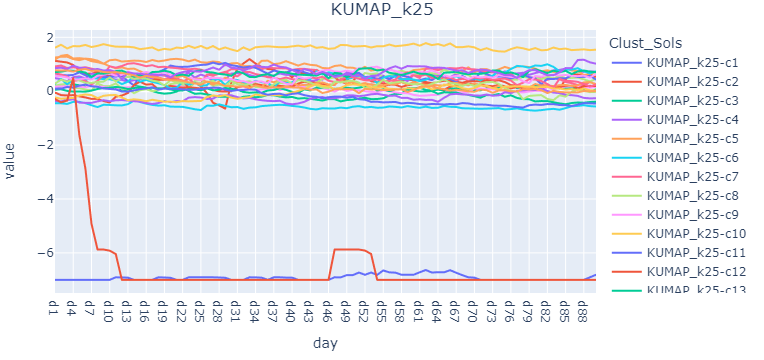

In [40]:
sol = 'KUMAP_k25'
sol_rows = []
for name in sol_names:
    n = name.split('-')[0]
    if n == sol:
        sol_rows.append(name)
        
df_centroids_melt = df_centroids[df_centroids['Clust_Sols'].isin(sol_rows)]
df_centroids_melt = pd.melt(df_centroids_melt, id_vars=['Clust_Sols'], value_vars=window_cols,
        var_name='day', value_name='value')

fig = px.line(df_centroids_melt, x="day", y="value", color='Clust_Sols')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20),
                 title={'text':f'{sol}', 'xanchor':'center', 'x':0.5})
fig.show()

In [1]:
# # Local df with relevant clustering solution
# df_clusters = df_sols[['short_ID', 'window_ID', 'UMAP_V1', 'UMAP_V2', sol]]

# #########################
# # Actual Plot
# # Start Figure
# fig = go.Figure()

# # Clustered Points by Colour
# # Show the selected clusters by their respective colours
# fig.add_trace(go.Scattergl(
#     x = df_clusters['UMAP_V1'],
#     y = df_clusters['UMAP_V2'],
#     mode='markers',
#     customdata = np.stack((df_clusters[sol], df_clusters['short_ID'], df_clusters['window_ID']), axis=-1),
#     hovertemplate ='<b>Cluster: %{customdata[0]}</b><br>ID: %{customdata[1]}<br>Window: %{customdata[2]}<extra></extra>',
#     marker=dict(
#         color= df_clusters[sol],
#         cmax = df_sols[sol].max(),
#         cmin = df_sols[sol].min(),                
#         colorscale= 'portland',  #turbo, rainbow, jet one of plotly colorscales
#         showscale= True    #set color equal to a variable
#     )
# )
#              )

# # Customising Appearance
# fig.update_layout(
#     margin=dict(l=20, r=20, t=20, b=20),
#     template= 'plotly_dark',
#     showlegend=False,
#     annotations=[go.layout.Annotation(
#                     font = {'size': 14},
#                     align='left',
#                     showarrow=False,
#                     xref='paper',
#                     yref='paper',
#                     x=0.01,
#                     y=0.95,
#                     )]
# )            


---
---
# Saving Outputs

In [41]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,KUMAP_k16,KUMAP_k17,KUMAP_k18,KUMAP_k19,KUMAP_k20,KUMAP_k21,KUMAP_k22,KUMAP_k23,KUMAP_k24,KUMAP_k25
0,127,0,2018-01-20,5.624063,13.729023,1,1,1,3,1,...,10,1,15,19,7,21,13,22,1,19
1,127,1,2018-04-20,5.561024,13.707704,1,1,1,3,1,...,10,1,15,19,7,21,13,22,1,19
2,127,2,2018-07-19,5.529921,14.151771,1,1,1,3,1,...,10,1,15,7,14,4,13,23,15,4
3,127,3,2018-10-17,3.812207,13.912416,1,1,1,3,1,...,16,6,16,12,18,9,18,8,24,17
4,127,4,2019-01-15,4.920882,15.008589,1,1,1,3,1,...,4,4,7,14,10,13,5,23,13,24


In [20]:
os.makedirs(f'../ModelResults/Clustering/{dataset_name}', exist_ok=True)  
solution_fileName = f'Shallow-Baseline.csv'
# df_sols.to_csv(f'../ModelResults/Clustering/{dataset_name}/{solution_fileName}', index=False)  